In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import sys
sys.setrecursionlimit(10000)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import re
import nltk
from nltk.util import pr
stemmer = nltk.SnowballStemmer("english")
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stopword = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("twitter_data.csv")
print(df.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [ ]:
df['labels'] = df['class'].map({0: "Hate speech detected", 1: "Offensive language detected", 2: "No hate and offensive speech"})
print(df.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                         labels  
0  No hate and offensive speech  
1   Offensive language detected  
2   Offensive language detected  
3   Offensive language detected  
4   Offensive language detected  


In [ ]:
df = df[['tweet', 'labels']]
df.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No hate and offensive speech
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language detected
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language detected
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language detected
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language detected


In [ ]:
import re
import string

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    return text

df["tweet"] = df["tweet"].apply(clean)
print(df.head())

                                               tweet  \
0   rt mayasolovely woman shouldnt complain clean...   
1   rt  boy dats coldtyga dwn bad cuffin dat hoe ...   
2   rt urkindofbrand dawg rt  ever fuck bitch sta...   
3           rt cganderson vivabased look like tranny   
4   rt shenikaroberts shit hear might true might ...   

                         labels  
0  No hate and offensive speech  
1   Offensive language detected  
2   Offensive language detected  
3   Offensive language detected  
4   Offensive language detected  


In [ ]:
x = np.array(df["tweet"])
y = np.array(df["labels"])

In [ ]:
print(df.isnull().sum())

tweet     0
labels    0
dtype: int64


In [ ]:
df = df.dropna(subset=["tweet", "labels"])

In [ ]:
df = df.fillna(0)

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
tokenized_tweets = df['tweet'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector
word2vec_features = tokenized_tweets.apply(
    lambda x: average_word_vectors(x, word2vec_model, word2vec_model.wv.index_to_key, 100)
)
word2vec_features = np.vstack(word2vec_features)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(word2vec_features, df["labels"], test_size=0.33, random_state=42)
w2v_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
w2v_classifier.fit(X_train_w2v, y_train_w2v)

RandomForestClassifier(random_state=42)

In [ ]:
cv = CountVectorizer()
x = cv.fit_transform(df["tweet"])
X_train, X_test, y_train, y_test = train_test_split(x, df["labels"], test_size=0.33, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(probability=True)
logreg_classifier = LogisticRegression()
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier),
    ('logreg', logreg_classifier)
], voting='soft')
ensemble_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True)),
                             ('logreg', LogisticRegression())],
                 voting='soft')

In [ ]:
VotingClassifier(estimators= [('rf', RandomForestClassifier(random_state = 42)),
                              ('svm', SVC(probability =True)),
                              ('logreg', LgisticRegression())],
                 voting = 'soft')

RandomForestClassifier(random_state = 42)
SVC(probabilty = True)
LogisticRegression()

DecisionTreeClassifier()
DecisionTreeClassifier(max_depth = 3)

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [ ]:
feature_names = cv.get_feature_names_out()
feature_importances = clf.feature_importances_
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_n = 10
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

bitch: 0.43171024112094253
bitches: 0.27774488614744236
hoes: 0.27656665013010434
nigga: 0.003921290078986518
faggots: 0.0036561315517577193
dyke: 0.0036444862918671756
lying: 0.002756314678899422
aa: 0.0
aaaaaaaaand: 0.0
aaahhhhh: 0.0


In [ ]:
proba_scores = clf.predict_proba(X_test)
threshold = 0.5
predictions = (proba_scores[:, 0] > threshold).astype(int)
print(predictions)

[0 0 0 ... 0 0 0]


In [ ]:
print(cv.get_feature_names_out())

['aa' 'aaaaaaaaand' 'aaahhhhh' ... 'zzzentropy' 'zzzquil' 'zzzzzz']


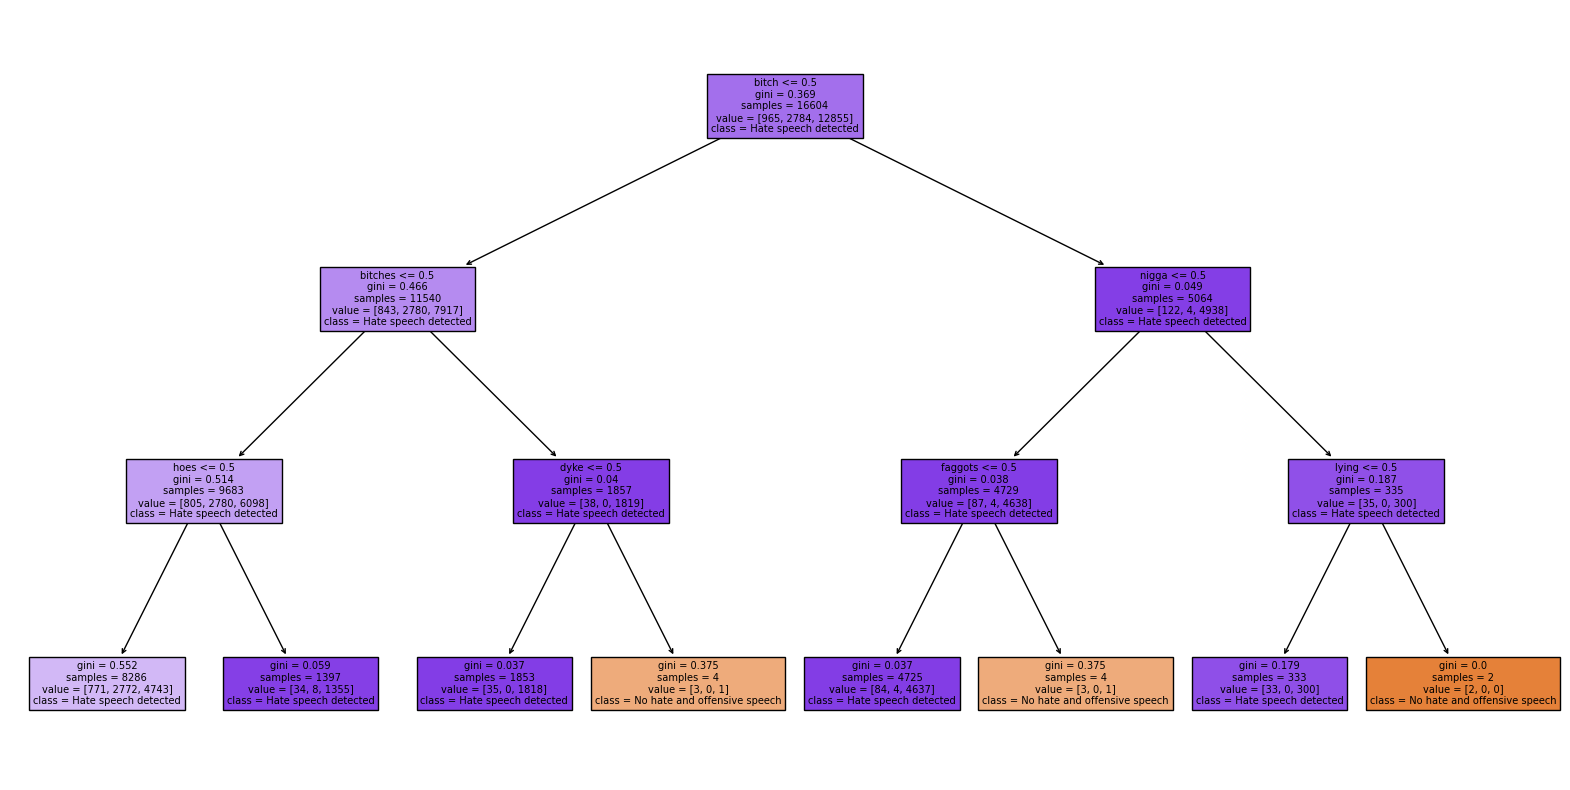

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=cv.get_feature_names_out(), class_names=df['labels'].unique())
plt.show()

In [ ]:
def predict_offensiveness(text):
    test_data_transformed = cv.transform([clean(text)]).toarray()
    prediction_probs = clf.predict_proba(test_data_transformed)[0]
    max_prob_index = np.argmax(prediction_probs)
    predicted_class = clf.classes_[max_prob_index]
    if predicted_class == "Offensive language detected":
        return "Offensive language detected"
    else:
        return "No hate and offensive speech"

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train_encoded)
xgb_predictions = xgb_classifier.predict(X_test)
xgb_predictions_labels = label_encoder.inverse_transform(xgb_predictions)
print(xgb_predictions_labels)

['Offensive language detected' 'Offensive language detected'
 'Offensive language detected' ... 'No hate and offensive speech'
 'Offensive language detected' 'Offensive language detected']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


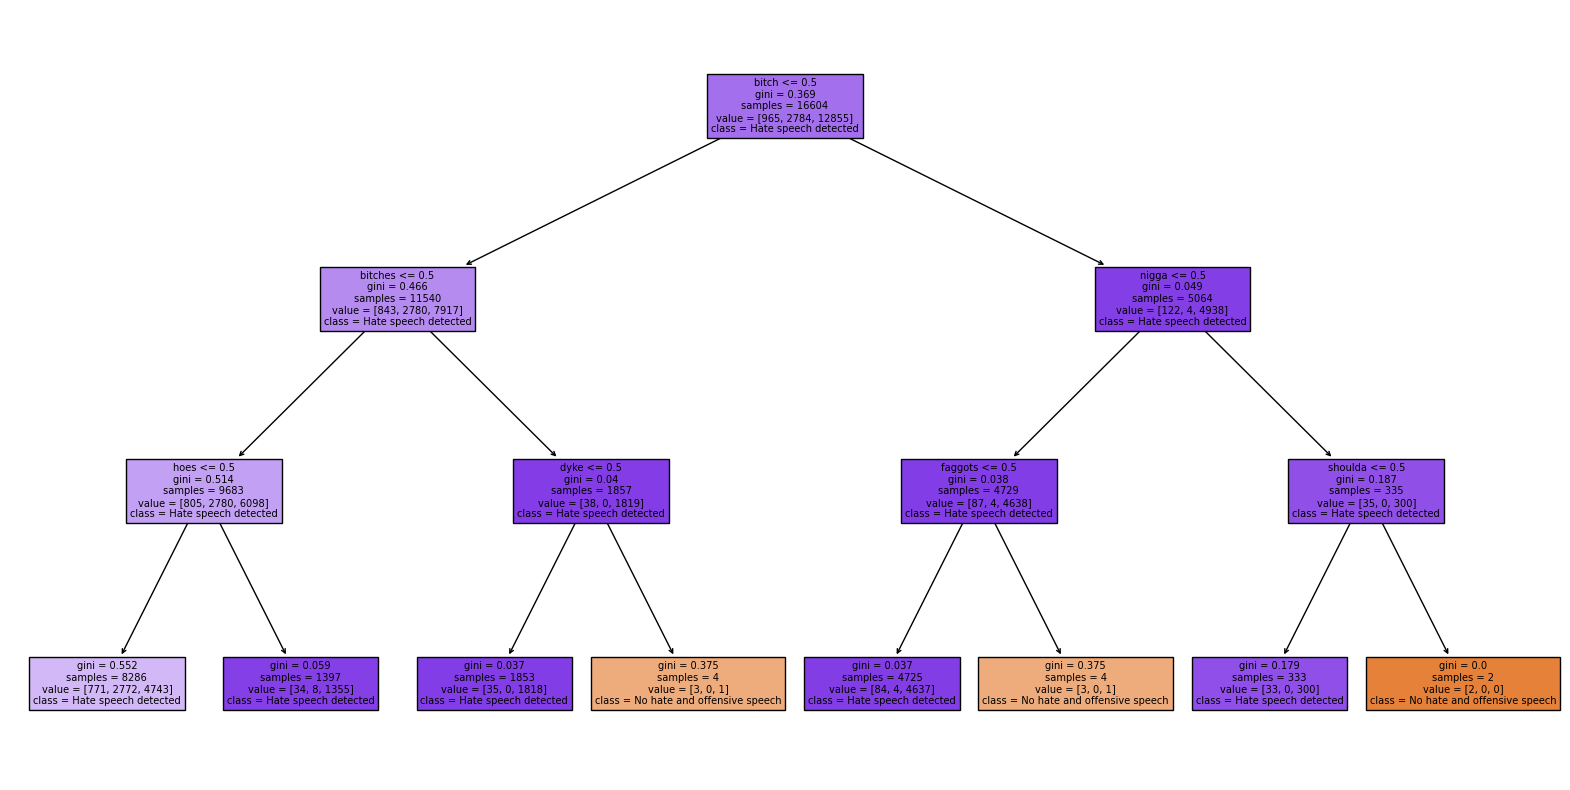

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

import sys
sys.setrecursionlimit(10000)

df = pd.read_csv("twitter_data.csv")

df['labels'] = df['class'].map({0: "Hate speech detected", 1: "Offensive language detected", 2: "No hate and offensive speech"})

df = df[['tweet', 'labels']]

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    return text

df["tweet"] = df["tweet"].apply(clean)

df = df.dropna(subset=["tweet", "labels"])

df = df.fillna(0)

tokenized_tweets = df['tweet'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)
word2vec_features = tokenized_tweets.apply(
    lambda x: average_word_vectors(x, word2vec_model, word2vec_model.wv.index_to_key, 100)
)
word2vec_features = np.vstack(word2vec_features)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(word2vec_features, df["labels"], test_size=0.33, random_state=42)
w2v_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
w2v_classifier.fit(X_train_w2v, y_train_w2v)

cv = CountVectorizer()
x = cv.fit_transform(df["tweet"])
X_train, X_test, y_train, y_test = train_test_split(x, df["labels"], test_size=0.33, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
svm_classifier = SVC(probability=True)
logreg_classifier = LogisticRegression()
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('svm', svm_classifier),
    ('logreg', logreg_classifier)
], voting='soft')
ensemble_model.fit(X_train, y_train)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train_encoded)

def predict_offensiveness_optimized(text):
    cleaned_text = clean(text)
    test_data_transformed = cv.transform([cleaned_text])

    ensemble_prediction = ensemble_model.predict(test_data_transformed)

    tree_prediction = clf.predict(test_data_transformed)

    xgb_prediction_encoded = xgb_classifier.predict(test_data_transformed)
    xgb_prediction_label = label_encoder.inverse_transform(xgb_prediction_encoded)

    return {
        'ensemble_prediction': ensemble_prediction[0],
        'tree_prediction': tree_prediction[0],
        'xgb_prediction': xgb_prediction_label[0]
    }

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=cv.get_feature_names_out(), class_names=df['labels'].unique())
plt.show()


In [ ]:
text1 = "I will kill you"
text2 = "She is a good girl"
text3 = "Murda Gang bitch its Gang Land"

result1 = predict_offensiveness_optimized(text1)
result2 = predict_offensiveness_optimized(text2)
result3 = predict_offensiveness_optimized(text3)

print(f"Text: {text1}\nPrediction: {result1}")
print(f"Text: {text2}\nPrediction: {result2}")
print(f"Text: {text3}\nPrediction: {result3}")

Text: I will kill you
Prediction: {'ensemble_prediction': 'Hate speech detected', 'tree_prediction': 'Offensive language detected', 'xgb_prediction': 'No hate and offensive speech'}
Text: She is a good girl
Prediction: {'ensemble_prediction': 'Offensive language detected', 'tree_prediction': 'Offensive language detected', 'xgb_prediction': 'No hate and offensive speech'}
Text: Murda Gang bitch its Gang Land
Prediction: {'ensemble_prediction': 'Offensive language detected', 'tree_prediction': 'Offensive language detected', 'xgb_prediction': 'Offensive language detected'}
